In [50]:
##importing model
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import  LSTM, SimpleRNN, GRU, Conv1D
from tensorflow.keras.layers import Bidirectional, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta
from tensorflow.keras.losses import Huber

In [51]:
# import os
# print(os.getcwd())  # Shows current working directory
# print(os.listdir())  # Lists all files in current directory

In [52]:
# Now load it the dataset
dftrain = pd.read_csv('Bike_train.csv')
dftest = pd.read_csv('Bike_test.csv')
df=pd.read_csv('Bike.csv')
df.head()

,Unnamed: 0,Count,Hour,Temp,Humidity,Wind,Visibility,DewTemp,SolarRad,Rainfall,Snowfall,Seasons,Holiday,FuncDay,Day,WeekDay,Month,Year
0,0,254.0,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
1,1,204.0,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
2,2,173.0,2.0,-6.0,39.0,1.0,2000.0,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
3,3,107.0,3.0,-6.2,40.0,0.9,2000.0,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
4,4,78.0,4.0,-6.0,36.0,2.3,2000.0,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017


In [53]:
dftest.head()

,Unnamed: 0,Date,Hour,Temperature(蚓),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day,WeekDay,Month,Year,RentalCount
0,6056,2018-08-10,8.0,27.2,69.0,1.8,1999.0,0.70,0.0,0.0,Summer,No Holiday,Yes,10,Friday,August,2018,1728.0
1,5556,2018-07-20,12.0,32.6,51.0,2.1,800.0,3.21,0.0,0.0,Summer,No Holiday,Yes,20,Friday,July,2018,822.0
2,5990,2018-08-07,14.0,34.0,50.0,1.2,1744.0,1.68,0.0,0.0,Summer,No Holiday,Yes,7,Tuesday,August,2018,658.0
3,7674,2018-10-16,18.0,16.9,47.0,1.4,1637.0,0.11,0.0,0.0,Autumn,No Holiday,Yes,16,Tuesday,October,2018,2716.0
4,3319,2018-04-18,7.0,6.4,51.0,1.0,1398.0,0.19,0.0,0.0,Spring,No Holiday,Yes,18,Wednesday,April,2018,1083.0


In [54]:
df.columns

Index(['Unnamed: 0', 'Count', 'Hour', 'Temp', 'Humidity', 'Wind', 'Visibility',
       'DewTemp', 'SolarRad', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday',
       'FuncDay', 'Day', 'WeekDay', 'Month', 'Year'],
      dtype='object')

In [55]:
feature_cols = ['Hour', 'Temp', 'Humidity', 'Wind', 'Visibility',
                 'SolarRad', 'Rainfall', 'Snowfall', 'Seasons', 
                 'Holiday','FuncDay', 'Day', 'WeekDay', 'Month', 'Year']

## separating predictors and target 
X = df[feature_cols]
y = df['Count']

In [56]:
X

,Hour,Temp,Humidity,Wind,Visibility,SolarRad,Rainfall,Snowfall,Seasons,Holiday,FuncDay,Day,WeekDay,Month,Year
0,0.0,-5.2,37.0,2.2,2000.0,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
1,1.0,-5.5,38.0,0.8,2000.0,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
2,2.0,-6.0,39.0,1.0,2000.0,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
3,3.0,-6.2,40.0,0.9,2000.0,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
4,4.0,-6.0,36.0,2.3,2000.0,0.0,0.0,0.0,Winter,No Holiday,Yes,1,Friday,December,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19.0,4.2,34.0,2.6,1894.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,30,Friday,November,2018
8756,20.0,3.4,37.0,2.3,2000.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,30,Friday,November,2018
8757,21.0,2.6,39.0,0.3,1968.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,30,Friday,November,2018
8758,22.0,2.1,41.0,1.0,1859.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,30,Friday,November,2018


In [57]:
# df.drop(columns='DewTemp', axis=1, inplace=True)

<h1 style="text-align:center; font-family:Georgia; color:white;">
    Data Preprocessing Steps
</h1>

In [58]:
# ##encoding
X['hour_sin']  = np.sin(2 * np.pi * X['Hour'] / 24)
X['hour_cos']  = np.cos(2 * np.pi * X['Hour'] / 24)

X['day_sin']   = np.sin(2 * np.pi * X['Day'] / 31)
X['day_cos']   = np.cos(2 * np.pi * X['Day'] / 31)

/var/folders/d2/v_pq11hn76q7r2f5yksqq2000000gn/T/ipykernel_30026/439570314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_sin']  = np.sin(2 * np.pi * X['Hour'] / 24)
/var/folders/d2/v_pq11hn76q7r2f5yksqq2000000gn/T/ipykernel_30026/439570314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour_cos']  = np.cos(2 * np.pi * X['Hour'] / 24)


In [59]:
##encoding: Label encoding
# cat_fet=[c for c in X.columns if X[c].dtype=='object']

# for i in cat_fet:
#     le=LabelEncoder()
#     X[i]=le.fit(X[i])
#     X[i]=le.transform(X[i])
# X.head()   

In [60]:
##feature encoding with LabelEncoder
le_seasons=LabelEncoder()
le_holiday=LabelEncoder()
le_weekday=LabelEncoder()
le_month=LabelEncoder()
le_funcday=LabelEncoder()
X['Seasons'] = le_seasons.fit_transform(X['Seasons'])
X['Holiday'] = le_holiday.fit_transform(X['Holiday'])
X['FuncDay'] = le_funcday.fit_transform(X['FuncDay'])
X['WeekDay'] = le_weekday.fit_transform(X['WeekDay'])
X['Month'] = le_month.fit_transform(X['Month'])

In [61]:
X.head()

,Hour,Temp,Humidity,Wind,Visibility,SolarRad,Rainfall,Snowfall,Seasons,Holiday,FuncDay,Day,WeekDay,Month,Year,hour_sin,hour_cos,day_sin,day_cos
0,0.0,-5.2,37.0,2.2,2000.0,0.0,0.0,0.0,3,1,1,1,0,2,2017,0.000000,1.000000,0.201299,0.97953
1,1.0,-5.5,38.0,0.8,2000.0,0.0,0.0,0.0,3,1,1,1,0,2,2017,0.258819,0.965926,0.201299,0.97953
2,2.0,-6.0,39.0,1.0,2000.0,0.0,0.0,0.0,3,1,1,1,0,2,2017,0.500000,0.866025,0.201299,0.97953
3,3.0,-6.2,40.0,0.9,2000.0,0.0,0.0,0.0,3,1,1,1,0,2,2017,0.707107,0.707107,0.201299,0.97953
4,4.0,-6.0,36.0,2.3,2000.0,0.0,0.0,0.0,3,1,1,1,0,2,2017,0.866025,0.500000,0.201299,0.97953


In [62]:
# import pickle
# with open('le_encoder.pkl', 'wb') as f:
# 	pickle.dump(le, f)

In [63]:
#Drop original column
X.drop(['Hour','Day'],axis=1,inplace=True)

In [64]:
##converting to numpy array
X_data=X.values ## (N, num_features)
y_data=y.values ## (N,)

In [65]:
X.columns

Index(['Temp', 'Humidity', 'Wind', 'Visibility', 'SolarRad', 'Rainfall',
       'Snowfall', 'Seasons', 'Holiday', 'FuncDay', 'WeekDay', 'Month', 'Year',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos'],
      dtype='object')

In [66]:
##separate the data into train and test data
train_size = int(len(df) * 0.8)

## take data upto assign train size value for training
X_train = X_data[:train_size]
y_train = y_data[:train_size]

##rest of the data after train size consider as testing data
X_test  = X_data[train_size:]
y_test = y_data[train_size:]

print(X_train.shape)
print(X_test.shape)

(7008, 17)
(1752, 17)


In [67]:
X

,Temp,Humidity,Wind,Visibility,SolarRad,Rainfall,Snowfall,Seasons,Holiday,FuncDay,WeekDay,Month,Year,hour_sin,hour_cos,day_sin,day_cos
0,-5.2,37.0,2.2,2000.0,0.0,0.0,0.0,3,1,1,0,2,2017,0.000000,1.000000,0.201299,0.97953
1,-5.5,38.0,0.8,2000.0,0.0,0.0,0.0,3,1,1,0,2,2017,0.258819,0.965926,0.201299,0.97953
2,-6.0,39.0,1.0,2000.0,0.0,0.0,0.0,3,1,1,0,2,2017,0.500000,0.866025,0.201299,0.97953
3,-6.2,40.0,0.9,2000.0,0.0,0.0,0.0,3,1,1,0,2,2017,0.707107,0.707107,0.201299,0.97953
4,-6.0,36.0,2.3,2000.0,0.0,0.0,0.0,3,1,1,0,2,2017,0.866025,0.500000,0.201299,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,4.2,34.0,2.6,1894.0,0.0,0.0,0.0,0,1,1,0,9,2018,-0.965926,0.258819,-0.201299,0.97953
8756,3.4,37.0,2.3,2000.0,0.0,0.0,0.0,0,1,1,0,9,2018,-0.866025,0.500000,-0.201299,0.97953
8757,2.6,39.0,0.3,1968.0,0.0,0.0,0.0,0,1,1,0,9,2018,-0.707107,0.707107,-0.201299,0.97953
8758,2.1,41.0,1.0,1859.0,0.0,0.0,0.0,0,1,1,0,9,2018,-0.500000,0.866025,-0.201299,0.97953


In [68]:
# Scaling independently for X and y
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

## scaler minmax
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1))

In [69]:
X_train_scaled

array([[0.22027972, 0.37755102, 0.2972973 , ..., 1.        , 0.60077861,
        0.98973865],
       [0.21503497, 0.3877551 , 0.10810811, ..., 0.98296291, 0.60077861,
        0.98973865],
       [0.20629371, 0.39795918, 0.13513514, ..., 0.9330127 , 0.60077861,
        0.98973865],
       ...,
       [0.69755245, 0.62244898, 0.2027027 , ..., 0.85355339, 0.25703718,
        0.06041634],
       [0.69230769, 0.66326531, 0.04054054, ..., 0.9330127 , 0.25703718,
        0.06041634],
       [0.68181818, 0.70408163, 0.17567568, ..., 0.98296291, 0.25703718,
        0.06041634]])

In [70]:
## Splitting the data into independent and target feature
## Parameter for sliding window
s_length=24, 

def create_sequences(data, target, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # (24, 18)
        y.append(target[i+seq_length])  # single value
    return np.array(X), np.array(y)

In [71]:
##sequaltial data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length=24)
X_test_seq, y_test_seq = create_sequences(X_test_scaled,y_test_scaled,seq_length=24)

print(X_train_seq.shape)   # (samples, 24, 18)
print(y_train_seq.shape)   # (samples,)

print(X_test_seq.shape)   # (samples, 24, 18)
print(y_test_seq.shape)   # (samples,)

(6984, 24, 17)
(6984, 1)
(1728, 24, 17)
(1728, 1)


In [72]:
#[0.01815, 64, 24, 10]
learning_rate = 0.01815
n_neurons = 100
n_timesteps = 24
n_epochs = 16
lss='mse'
metrics=['mae']
bs=32

<h1 style="text-align:center; font-family:Georgia; color:white;">
    Model Training Pipeline
</h1>

In [73]:
##LSTM
#[0.01815, 64, 24, 10]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# earlyStop=EarlyStopping(
#     monitor='val_loss',
#     patience=5, ##stop if no improvements after 5 epochs
    # restore_best_weights=True ## bring back the best model
# )

lstm_model = Sequential([
    LSTM(n_neurons, activation="relu", return_sequences=True,
             input_shape=(24, X_train_seq.shape[2])),
    # LSTM(n_neurons, activation="relu", return_sequences=True, recurrent_dropout=0.2), ##without this layer gives 60%
    # LSTM(n_neurons, activation="relu", return_sequences=True), #100 neurons give 60%
    LSTM(n_neurons, activation="relu"), ##100 neurons give 60%
    Dense(32, activation="relu"), ## 32 giving 60%
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss=Huber(), metrics=metrics)
lstm_model.summary()

lstm_model.fit(X_train_seq, y_train_seq, 
               epochs=16, 
               batch_size=bs,
            #    validation_split=0.2,
            #    shuffle=False,
            #    callbacks=[earlyStop]
               )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 100)        │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,865 (511.19 KB)

 Trainable params: 130,865 (511.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0071 - mae: 0.0828
Epoch 2/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0047 - mae: 0.0650
Epoch 3/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0039 - mae: 0.0591
Epoch 4/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0035 - mae: 0.0554
Epoch 5/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0032 - mae: 0.0523
Epoch 6/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0030 - mae: 0.0504
Epoch 7/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0027 - mae: 0.0480
Epoch 8/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0027 - mae: 0.0475
Epoch 9/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0024 - mae: 0.0454
Epoch 10/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0023 - mae: 0.0437
Epoch 11/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0021 - mae: 0.0421
Epoch 12/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0020 - mae: 0.0414
Epoch 13/16
2

In [74]:
#GRU
seed=np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
grumodel = Sequential([
    GRU(n_neurons, return_sequences=True, input_shape=(n_timesteps, X_train_seq.shape[2])),
    GRU(64, return_sequences=False, input_shape=(n_timesteps, X_train_seq.shape[2])),
    Dense(32, activation="tanh"),
    Dense(1)
])

adop = Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    beta_2=0.9,
    epsilon=0.03,
    amsgrad=True
)
# adop=Adam(learning_rate=learning_rate,momentum=0.9)
grumodel.compile(optimizer=adop, loss=lss,metrics=metrics)
grumodel.summary()

grumodel.fit(X_train_seq,y_train_seq, epochs=n_epochs, batch_size=bs)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 100)        │        35,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,685 (272.21 KB)

 Trainable params: 69,685 (272.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0856 - mae: 0.1872
Epoch 2/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0174 - mae: 0.0969
Epoch 3/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0142 - mae: 0.0839
Epoch 4/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0129 - mae: 0.0787
Epoch 5/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0120 - mae: 0.0766
Epoch 6/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0113 - mae: 0.0744
Epoch 7/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0109 - mae: 0.0736
Epoch 8/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0107 - mae: 0.0728
Epoch 9/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0105 - mae: 0.0723
Epoch 10/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0104 - mae: 0.0717
Epoch 11/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0102 - mae: 0.0709
Epoch 12/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0100 - mae: 0.0702
Epoch 13/16
2

In [75]:
## CNN + LSTM Hybrid Model
cnn_lstm_model = Sequential([
    Conv1D(filters=256, kernel_size=4, activation='tanh', input_shape=(24, X_train_seq.shape[2])),
    MaxPooling1D(pool_size=3),
    LSTM(n_neurons, activation="tanh", return_sequences=False,
        input_shape=(24, X_train_seq.shape[2])),
    Dense(32, activation='tanh'),
    Dense(1)
])

cnn_lstm_model.compile(optimizer=Adam(learning_rate), loss=lss, metrics=metrics)
cnn_lstm_model.summary()

cnn_lstm_model.fit(X_train_seq, y_train_seq, 
                   epochs=n_epochs, 
                   batch_size=bs,
                   )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 21, 256)        │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,729 (639.57 KB)

 Trainable params: 163,729 (639.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1303 - mae: 0.1755
Epoch 2/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0183 - mae: 0.0990
Epoch 3/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0154 - mae: 0.0890
Epoch 4/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0136 - mae: 0.0828
Epoch 5/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0133 - mae: 0.0819
Epoch 6/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0151 - mae: 0.0881
Epoch 7/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0133 - mae: 0.0834
Epoch 8/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0129 - mae: 0.0816
Epoch 9/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0125 - mae: 0.0805
Epoch 10/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0119 - mae: 0.0788
Epoch 11/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0121 - mae: 0.0803
Epoch 12/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0121 - mae: 0.0797
Epoch 13/16
219/219 

In [76]:
#[0.01815, 64, 24, 10]
# learning_rate = 0.01815
# n_neurons = 64
# n_timesteps = 24
# n_epochs = 16
# lss='mse'
# metrics=['mae']
# bs=32
seed=np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
model_rnn = Sequential([
    SimpleRNN(n_neurons, activation="tanh", return_sequences=True, input_shape=(n_timesteps,X_train_seq.shape[2]), unroll=True),
    SimpleRNN(n_neurons, activation="tanh", return_sequences=True, input_shape=(n_timesteps,X_train_seq.shape[2]), unroll=True),
    SimpleRNN(64, activation="tanh", return_sequences=False, input_shape=(n_timesteps,X_train_seq.shape[2]), unroll=True),
    Dense(64, activation="tanh"),
    Dense(1)  # linear output
])

##optimizer
# optim=SGD(learning_rate=learning_rate, momentum=0.5)
model_rnn.compile(optimizer='adam',loss=Huber(),metrics=metrics)
model_rnn.fit(X_train_seq,
              y_train_seq,
              epochs=n_epochs,
              batch_size=bs)

Epoch 1/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0138 - mae: 0.1082
Epoch 2/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0061 - mae: 0.0790
Epoch 3/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0053 - mae: 0.0732
Epoch 4/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0045 - mae: 0.0673
Epoch 5/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0041 - mae: 0.0641
Epoch 6/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0039 - mae: 0.0623
Epoch 7/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036 - mae: 0.0598
Epoch 8/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034 - mae: 0.0583
Epoch 9/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0032 - mae: 0.0567
Epoch 10/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - mae: 0.0555
Epoch 11/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - mae: 0.0541
Epoch 12/16
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - mae: 0.0537
Epoch 13/16
219/219

In [77]:
##prediction
gru_pred  = grumodel.predict(X_test_seq)
lstm_pred = lstm_model.predict(X_test_seq)
cnn_pred  = cnn_lstm_model.predict(X_test_seq)
y_pred_rnn=model_rnn.predict(X_test_seq)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [78]:
##inverse transformation
# pred_scaled = your predicted values array
# scaler_y = MinMaxScaler fitted on y_train (Bike Rental Count)

def inverse_transform_prediction(prediction, scaler):
    y_pred=prediction.reshape(-1,1)
    y_pred_original=scaler.inverse_transform(y_pred)
    y_pred_flatten=y_pred_original.flatten() #shape (num_rows,)
    return y_pred_flatten 

In [79]:

# Convert scaled predictions back to original counts
gru_final  = inverse_transform_prediction(gru_pred,scaler_y)
lstm_final=inverse_transform_prediction(lstm_pred,scaler_y)
cnn_final  = inverse_transform_prediction(cnn_pred,scaler_y)
rnn_final=inverse_transform_prediction(y_pred_rnn,scaler_y)

In [80]:
rnn_final

array([382.83572, 414.8726 , 382.13477, ..., 902.30927, 776.2483 ,
       629.3564 ], dtype=float32)

<h1 style="text-align:center; font-family:Georgia; color:white;">
    Evaluation The Model
</h1>

In [81]:
##evaluation of the three models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate(true, pred, name):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(true[24:], pred))
    print("RMSE:", np.sqrt(mean_squared_error(true[24:], pred)))
    print("r2:", r2_score(true[24:], pred))

evaluate(y_test, gru_final,  "GRU")
evaluate(y_test, lstm_final, "LSTM")
evaluate(y_test, cnn_final,  "CNN + LSTM")
evaluate(y_test, rnn_final,  "RNN")


GRU Performance:
MAE: 316.2578105494656
RMSE: 418.0374828606681
r2: 0.5319033457705129

LSTM Performance:
MAE: 400.75971680359606
RMSE: 523.8553562950071
r2: 0.26493140814744653

CNN + LSTM Performance:
MAE: 452.034980641471
RMSE: 581.4344573642475
r2: 0.09446212423997291

RNN Performance:
MAE: 241.66094467530235
RMSE: 342.9867149440099
r2: 0.6848918135733872


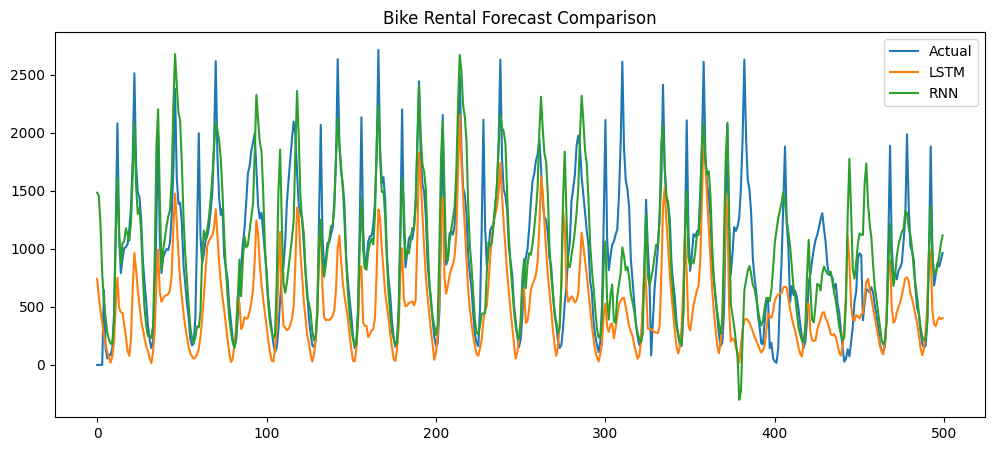

In [82]:
plt.figure(figsize=(12,5))
plt.plot(y_test[500:1000], label="Actual")
# plt.plot(gru_final[500:1000], label="GRU")
plt.plot(lstm_final[500:1000], label="LSTM")
# plt.plot(cnn_final[500:1000], label="CNN+LSTM")
plt.plot(rnn_final[500:1000], label="RNN")
plt.legend()
plt.title("Bike Rental Forecast Comparison")
plt.show()

In [83]:
RNNloss_df = pd.DataFrame(model_rnn.history.history)
GRUloss_df = pd.DataFrame(grumodel.history.history)
LSTMloss_df = pd.DataFrame(lstm_model.history.history)
CNNLSTMloss_df = pd.DataFrame(cnn_lstm_model.history.history)

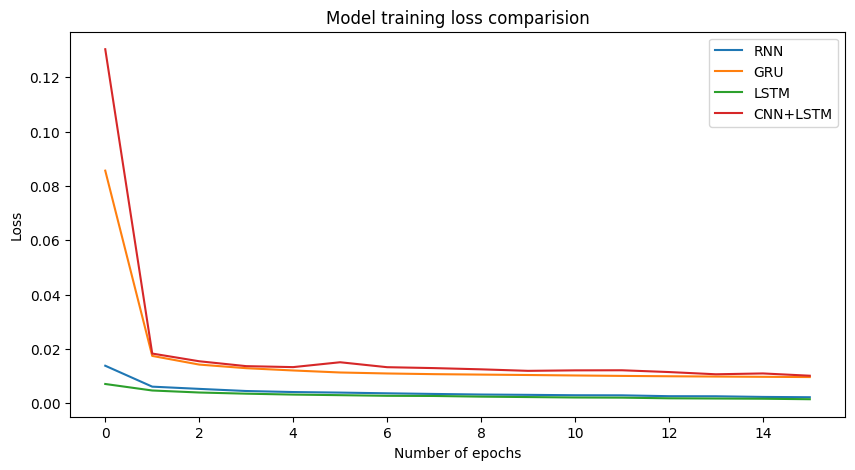

In [84]:
##plot loss
plt.figure(figsize=(10,5))
plt.plot(RNNloss_df['loss'], label='RNN')
plt.plot(GRUloss_df['loss'], label='GRU')
plt.plot(LSTMloss_df['loss'], label='LSTM')
plt.plot(CNNLSTMloss_df['loss'],label='CNN+LSTM')
plt.title("Model training loss comparision")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [85]:
tf.__version__

'2.19.0'

In [86]:
3/b

NameError: name 'b' is not defined

In [ ]:
##checks 
RNNloss_df
model_rnn.history.history.keys()


<h1 style="text-align:center; font-family:Georgia; color:white;">
    Validation and Training Loss Checks
</h1>

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(LSTMloss_df['loss'], label='Train Loss')
# plt.plot(LSTMloss_df['val_loss'], label='Validation Loss')
# plt.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Loss (MAE or MSE)")
# plt.title("Training vs Validation Loss")
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(RNNloss_df['loss'], label='Train Loss')
# plt.plot(RNNloss_df['val_loss'], label='Validation Loss')
# plt.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Loss (MAE or MSE)")
# plt.title("Training vs Validation Loss")
# plt.show()

In [ ]:
##saving model for testing
# lstm_model.save("lstm.h5")

In [ ]:
# ##save scaling model as well
# import pickle
# with open("scaler_X","wb") as f:
#     pickle.dump(scaler_X, f)

# with open("scaler_y","wb") as f:
#     pickle.dump(scaler_y,f)

<h1 style="text-align:center; font-family:Georgia; color:white;">
    Prediction On New Data
</h1>

In [ ]:
## receive the data from users for single prediction
rawdata = [
        {"Hour": 8, "Temp": 19.0, "Humidity": 65, "Wind": 4.0, "Visibility": 1800, 
         "SolarRad": 0.5, "Rainfall": 0.0, "Snowfall": 0.0,
         "Seasons": 'Winter', "Holiday": 'No Holiday', "FuncDay": 'Yes', "Day": 1, "WeekDay": 'Friday', "Month": 'December', "Year": 2024}]
        
rawdata1 = [{"Hour": 12, "Temp": 22.0, "Humidity": 55, "Wind": 1.5, "Visibility": 2000,
         "SolarRad": 1.5, "Rainfall": 0.0, "Snowfall": 0.0,
         "Seasons": 'Summer', "Holiday": 'Holiday', "FuncDay": 'No', "Day": 1, "WeekDay": 'Thursday', "Month": 'June', "Year": 2024}]
        
rawdata2 = [{"Hour": 18, "Temp": 20.0, "Humidity": 43, "Wind": 2.0, "Visibility": 1900,
         "SolarRad": 0.8, "Rainfall": 0.0, "Snowfall": 0.0,
         "Seasons": 'Spring', "Holiday": 'No Holiday', "FuncDay": 'Yes', "Day": 1, "WeekDay": 'Monday', "Month": 'March', "Year": 2024}]

In [ ]:
feat=['Temp', 'Humidity', 'Wind', 'Visibility',
       'DewTemp', 'SolarRad', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday',
       'FuncDay', 'WeekDay', 'Month', 'Year']

In [ ]:
##convert into dataframe
df_data= pd.DataFrame(rawdata1)
# df_data1= pd.DataFrame(rawdata1)
# df_data2= pd.DataFrame(rawdata2)
df_data.head()

In [ ]:
##encoding hours and day
df_data['hour_sin']  = np.sin(2 * np.pi * df_data['Hour'] / 24)
df_data['hour_cos']  = np.cos(2 * np.pi * df_data['Hour'] / 24)

df_data['day_sin']   = np.sin(2 * np.pi * df_data['Day'] / 31)
df_data['day_cos']   = np.cos(2 * np.pi * df_data['Day'] / 31)

In [ ]:
df_data

In [ ]:
# Use the same encoders as in training for all categorical columns
# 'le' was already fit on training data for 'Seasons'

df_data['Holiday'] = le_holiday.transform(df_data['Holiday'])
df_data['Seasons'] = le_seasons.transform(df_data['Seasons'])
df_data['FuncDay'] = le_funcday.transform(df_data['FuncDay'])
df_data['WeekDay'] = le_weekday.transform(df_data['WeekDay'])
df_data['Month'] = le_month.transform(df_data['Month'])



In [ ]:
df_data

In [ ]:
df_data.drop(['Hour','Day'],axis=1,inplace=True)

In [ ]:
##scaling on only predictor features
feat=['Temp', 'Humidity', 'Wind', 'Visibility', 'SolarRad',
       'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'FuncDay',
       'WeekDay', 'Month', 'Year', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos']
x_sc=scaler_X.transform(df_data[feat])


In [ ]:
# Create a sequence by repeating the single input 24 times to form a complete sequence
x_input = np.repeat(x_sc, 24, axis=0).reshape(1, 24, x_sc.shape[1])

# Make predictions with all models
rnn_pred_single = model_rnn.predict(x_input)

# Inverse transform predictions
rnn_pred_final = inverse_transform_prediction(rnn_pred_single, scaler_y)


print("RNN Prediction:", rnn_pred_final[0])

<h1 style="text-align:center; font-family:Georgia; color:white;">
    One Complete Prediction Pipeline
</h1>

In [ ]:
##one complete code for prediction

##receive the data from users for single prediction
feat=['Hour', 'Temp', 'Humidity', 'Wind', 'Visibility', 'SolarRad',
       'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'FuncDay', 'Day',
       'WeekDay', 'Month', 'Year', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos']

# convert into dataframe
df_data= pd.DataFrame(rawdata)

##encoding hours and day
df_data['hour_sin']  = np.sin(2 * np.pi * df_data['Hour'] / 24)
df_data['hour_cos']  = np.cos(2 * np.pi * df_data['Hour'] / 24)

df_data['day_sin']   = np.sin(2 * np.pi * df_data['Day'] / 31)
df_data['day_cos']   = np.cos(2 * np.pi * df_data['Day'] / 31)

# Use the same encoders as in training for all categorical columns
# 'le' was already fit on training data for 'Seasons'

df_data['Holiday'] = le_holiday.transform(df_data['Holiday'])
df_data['Seasons'] = le_seasons.transform(df_data['Seasons'])
df_data['FuncDay'] = le_funcday.transform(df_data['FuncDay'])
df_data['WeekDay'] = le_weekday.transform(df_data['WeekDay'])
df_data['Month'] = le_month.transform(df_data['Month'])

##scaling on only predictor features
x_sc=scaler_X.transform(df_data[feat])


# Create a sequence by repeating the single input 24 times to form a complete sequence
x_input = np.repeat(x_sc, 24, axis=0).reshape(1, 24, 19)

# Make predictions with all models
rnn_pred_single = model_rnn.predict(x_input)

# Inverse transform predictions
rnn_pred_final = inverse_transform_prediction(rnn_pred_single, scaler_y)


print("RNN Prediction:", rnn_pred_final[0])

# Hyperparameter Tuning

In [ ]:
learning_rate = [0.01815,0.0031,0.012]
n_neurons = [120,64]
n_timesteps = [24]
n_epochs = [10,16]

In [ ]:
hyper_para = (learning_rate, n_neurons, n_timesteps, n_epochs)
hyper_para_grid = tuple(itertools.product(*hyper_para, repeat=1))

In [ ]:
print(len(hyper_para_grid))

In [ ]:
# for learning_rate, n_neurons, n_timesteps, n_epochs in hyper_para_grid:
#   print('lr',learning_rate, 'n_neurons', n_neurons, 'n_timesteps', n_timesteps,'n_epochs', n_epochs)

In [ ]:
# train_loss_grid, val_loss_grid = list(), list()
best_params = []
def fit_lstm_grid(batch_size):
  min_val_loss = 999
  current_val_loss = 0
  for learning_rate, n_neurons, n_timesteps, n_epochs in hyper_para_grid:
    print('lr',learning_rate, 'n_neurons', n_neurons, 'n_timesteps', n_timesteps,'n_epochs', n_epochs)
    model = Sequential()
    model.add(Bidirectional(LSTM(n_neurons,return_sequences=True,input_shape=(n_timesteps,X_train_seq.shape[2]))))
    model.add(LSTM(n_neurons))
    model.add(Dropout(0.25))
    model.add(Dense(1,activation='tanh'))
    model.compile(loss='mse',optimizer=Adam(learning_rate),metrics=['mae'])
    # fit model
    lstm_model = model.fit(X_train_seq,y_train_seq,epochs=n_epochs,batch_size=batch_size, validation_split=0.15)
    current_val_loss = lstm_model.history['val_loss'][-1]
    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params = [learning_rate,n_neurons,n_timesteps,n_epochs]
      print('best_params',best_params)
    
  return best_params

In [ ]:
fit_lstm_grid(32)

<h1 style="text-align:center; font-family:Georgia; color:white;">
    Saving the Required Model, Scaler, Encoder
</h1>

In [ ]:
# ## saving the model
# model_rnn.save("rnn_model.h5")

## saving the scaler x 
with open("scaler_X","wb") as scx:
    pickle.dump(scaler_X,scx)

## saving the scaler y
with open("scaler_y","wb") as scy:
    pickle.dump(scaler_y,scy)

##saving the label encoders for each separate categorical feature
with open("le_seasons","wb") as les:
    pickle.dump(le_seasons,les)

with open("le_holiday","wb") as leh:
    pickle.dump(le_holiday,leh)

with open("le_funcday","wb") as lef:
    pickle.dump(le_funcday,lef)

with open("le_weekday","wb") as lew:
    pickle.dump(le_weekday,lew)

with open("le_month","wb") as lem:
    pickle.dump(le_month,lem)



In [ ]:
import sys
import importlib
from fastapi import FastAPI
# List of packages to check
packages = [
    "fastapi",
    "numpy",
    "tensorflow",
    "matplotlib",
    "sklearn",
    "pydantic",
    "uvicorn",
    "itertools",
    "os",
    "pickle",
    "pandas"
]

print("=== Installed Package Versions ===")

for pkg in packages:
    try:
        module = importlib.import_module(pkg)
        version = module.__version__
        print(f"{pkg}: {version}")
    except ImportError:
        print(f"{pkg}: NOT INSTALLED")
    except AttributeError:
        # Some modules may not expose __version__
        print(f"{pkg}: Installed (version attribute not found)")

print("\n=== Built-in Python Modules (No Version) ===")
builtins = ["pickle", "random", "os", "itertools", "sys"]
for b in builtins:
    print(f"{b}: Built-in module (comes with Python {sys.version.split()[0]})")

In [ ]:
pip install keras-tuner numpy tensorflow matplotlib scikit-learn fastapi uvicorn pydantic